In [2]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../utils')
from tools import load_for_jupyter

n = 10000
v_sets, e_sets, core_targets, ext_targets, v_sample, e_sample = load_for_jupyter(n)

Dataset already downloaded. Loading it from file system
LOADING DATA: 0.99 s
SUBSAMPLING: 0.06 s
PREPROCESSING: 0.05 s


In [4]:
batch_size = 300
epochs = 15
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [5]:
# Initialize SG graph
G = sg.StellarDiGraph(v_sets, e_sets)

In [6]:
nodes_with_labels = v_sets.copy()

In [7]:
ext_targets.size

2725

In [8]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 19005, Edges: 10000

 Node types:
  Account: [10916]
    Features: float32 vector, length 3
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3429]
    Features: float32 vector, length 5
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [3040]
    Features: float32 vector, length 4
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1183]
    Features: float32 vector, length 4
    Edge types: none
  Address: [437]
    Features: float32 vector, length 2
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3204]
        Weights: range=[1, 500], mean=186.106, std=225.84
        Features: none
    Customer-has account->Account: [2998]
        Weights: all 1 (default)
        Features: none
    Derived Entity-is similar->External 

In [9]:
# Split edges into train and test sets

train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=train_size, test_size=test_size, #stratify=ext_targets
)

In [10]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]

In [11]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
test_targets = target_encoding.transform(test_ID)

In [12]:
train_ID.shape

(848, 1)

In [13]:
train_targets.shape

(848, 665)

In [14]:
# Choosing a 2 layer model with 8 nodes sampled in the first layer and 4 in the second.
num_samples = [8, 4]
# we can do 8*4 = 32x32 hidden layer size, since len(num_samples) defines 
# the number of hops (layers) in the HinSAGE model

In [15]:
'''
HinSAGENodeGenerator(G, batch_size, num_samples, head_node_type=None, schema=None, seed=None, name=None)

G = graph
batch_size = size of batch to return
num_samples = the number of samples per layer (hop) to take
head_node_type = the node type that will be given to the generator using the flow method. 
                  The model will expect this type.
                  If not given, it defaults to a single node type.
'''

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [16]:
# Flow

train_gen = generator.flow(train_ID.index, train_targets, shuffle=True)
test_gen = generator.flow(test_ID.index, test_targets)

In [17]:
generator.schema.schema

{'Derived Entity': [EdgeType(n1='Derived Entity', rel='is similar', n2='External Entity'),
  EdgeType(n1='Derived Entity', rel='money transfer', n2='Account')],
 'Address': [],
 'Account': [EdgeType(n1='Account', rel='money transfer', n2='Account'),
  EdgeType(n1='Account', rel='money transfer', n2='Derived Entity')],
 'Customer': [EdgeType(n1='Customer', rel='has account', n2='Account'),
  EdgeType(n1='Customer', rel='has address', n2='Address'),
  EdgeType(n1='Customer', rel='is similar', n2='External Entity')],
 'External Entity': []}

In [18]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [19]:
# Dropout
# (must be tuned)

dropout = 0.5

In [20]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [21]:
x_inp, x_out = hinsage.in_out_tensors()

In [22]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    #do TSNE here
    return x_emb_in, x_emb_out, model


Epoch 1/15
37/37 [==============================] - 8s 208ms/step - loss: 0.6487 0s - loss: 0
Epoch 2/15
37/37 [==============================] - 7s 193ms/step - loss: 0.5456
Epoch 3/15
37/37 [==============================] - 7s 196ms/step - loss: 0.4857
Epoch 4/15
37/37 [==============================] - 7s 193ms/step - loss: 0.4513
Epoch 5/15
37/37 [==============================] - 7s 195ms/step - loss: 0.4406
Epoch 6/15
37/37 [==============================] - 7s 194ms/step - loss: 0.4345
Epoch 7/15
37/37 [==============================] - 7s 197ms/step - loss: 0.4193 4s - loss: 0.421 -
Epoch 8/15
37/37 [==============================] - 7s 197ms/step - loss: 0.4125
Epoch 9/15
37/37 [==============================] - 8s 212ms/step - loss: 0.3976
Epoch 10/15
37/37 [==============================] - 8s 207ms/step - loss: 0.3952
Epoch 11/15
37/37 [==============================] - 8s 204ms/step - loss: 0.3881 4s - loss: 0 - ET
Epoch 12/15
37/37 [==============================] - 8s 2

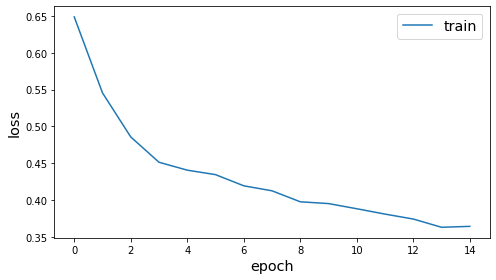

In [23]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [24]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
all_embeddings = emb_model.predict(
    #use a heterogeneous generator...
    generator.flow(G.nodes(node_type="Account"))
)

In [25]:
embeddings_2d = pd.DataFrame(TSNE(n_components=2).fit_transform(all_embeddings), index=G.nodes(node_type="Account"))

In [26]:
embeddings_2d.head()

,0,1
1502001,-13.370721,28.529457
1502004,-13.370721,28.529457
1502008,-14.302681,27.632036
15020010,-1.318046,-0.440267
15020015,39.023479,17.552708


In [27]:
# draw the points
node_ids = G.nodes(node_type="Account").tolist()
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

In [28]:
len(node_ids)

10916

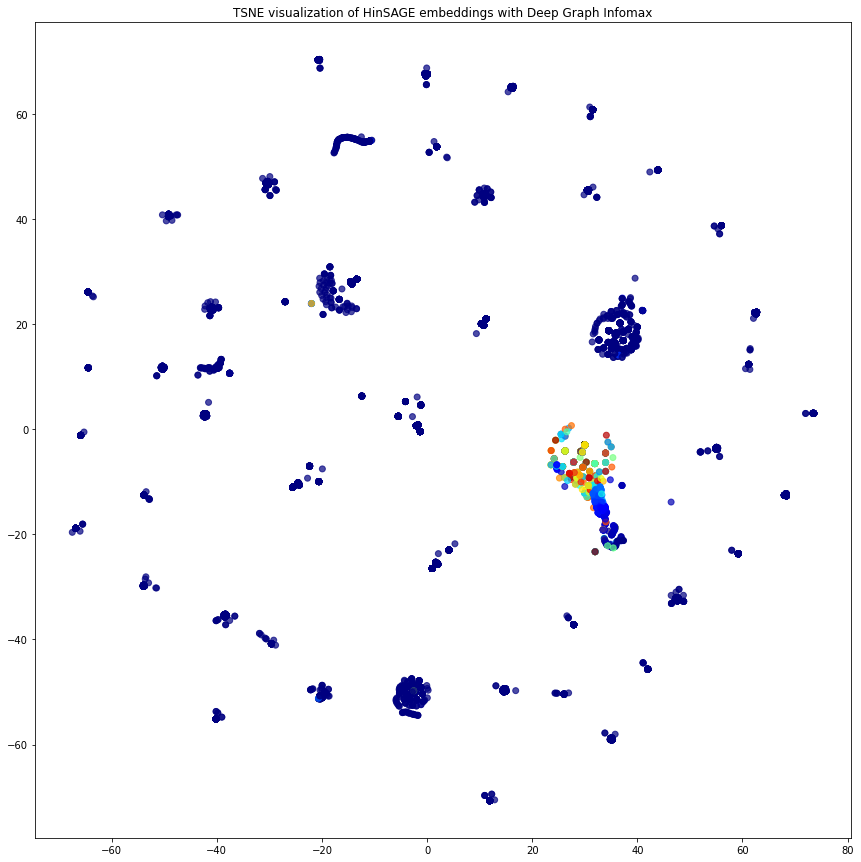

In [29]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [30]:
all_embeddings.shape

(10916, 32)

In [31]:
node_ids_full = np.concatenate((
    G.nodes(node_type='Account'), 
    G.nodes(node_type='Customer'), 
    G.nodes(node_type='Derived Entity')
)).tolist()

In [32]:
len(node_ids_full)

17385

In [33]:
len(np.concatenate((
    all_embeddings,
    all_embeddings
)))
#Perfect

21832

In [34]:
# I have all the embeddings.
# Now: classification time!

In [35]:
# Split in train(70%), test(15%) and validation set (15%)
train_ID, test_ID = model_selection.train_test_split(
ext_targets, train_size=0.7, test_size=None, #stratify=ext_targets
)
val_ID, test_ID = model_selection.train_test_split(
test_ID, train_size=0.5, test_size=None, #stratify=test_ID
)
print("train/val/test: ",len(train_ID.index),len(val_ID.index),len(test_ID.index))

train/val/test:  7641 1637 1638


In [36]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
val_targets = target_encoding.transform(val_ID)
test_targets = target_encoding.transform(test_ID)

In [37]:
# Another approach

In [38]:
X = all_embeddings
y = np.array(ext_targets)

In [39]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.3, test_size=None)

In [40]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (3274, 32)
 y_train = (3274,)
 X_test = (7642, 32)
 y_test = (7642,)


In [41]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

/Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [42]:
y_pred = clf.predict(X_test)

In [43]:
accuracy_score(y_test, y_pred)

0.8858937450929076

In [52]:
f1_score(y_test, y_pred, average='weighted')

0.8322926247958624

In [81]:
len(y_pred)

7642

In [78]:
equal = 0
notzero_pred = 0
notzero_test = 0
for i in range(len(y_pred)):
    if y_pred[i] != 0.0:
        notzero_pred += 1
    if y_test[i] != 0.0:
        notzero_test += 1
    if y_pred[i] == y_test[i]:
        equal += 1

In [79]:
notzero_pred

0

In [80]:
notzero_test

872

In [82]:
X_test[0]

array([0.3440975 , 0.3045484 , 0.14596634, 0.05210739, 0.02074994,
       0.0541058 , 0.01335938, 0.09324198, 0.18507522, 0.13704002,
       0.33342302, 0.5248797 , 0.29229513, 0.15258318, 0.02096614,
       0.01560746, 0.09959745, 0.10159349, 0.07026795, 0.08993376,
       0.16910568, 0.12907577, 0.1359508 , 0.1138306 , 0.08793345,
       0.11006191, 0.14511956, 0.07740608, 0.10131039, 0.07347663,
       0.08399951, 0.15463452], dtype=float32)

In [83]:
y_test[0]

0.0

In [ ]:
# TO TEST: CLASSIFICATION::
def run_classify(x_emb_in, x_emb_out, train_ID, test_ID):
    #train_subjects, test_subjects = model_selection.train_test_split(
    #    subjects, train_size=0.1, test_size=None)
    
    train_subjects = train_ID
    test_subjects = test_ID
    
    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    #ordered_test_subjects = reorder(test_gen, test_subjects)
    #ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc, x_emb_out